In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
plt.rcParams['figure.figsize'] = (16, 4)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm

from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid

from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed

%matplotlib inline 

import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

<AxesSubplot:xlabel='date'>

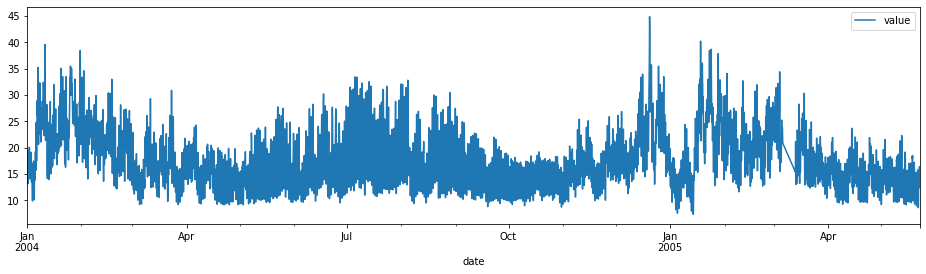

In [21]:
#read files from previous jupyter

df_area_1 = pd.read_pickle('data/clean/df_area_1.pickle') #(12192, 1)
df_area_3 = pd.read_pickle('data/clean/df_area_3.pickle') #(15480, 1)
df_area_3 = pd.read_pickle('data/clean/df_area_3.pickle') #(17160, 1)
df_area_1.head()

df_area_1.plot()

In [4]:
def build_target(series_, number_of_periods_ahead):
    """ 
    takes a series, turned it into a dataframe, and adds a new column called target
    This column is the input series, lagged number_of_periods_ahead into the future
    """
    
    # make a copy 
    series_ = series_.copy()
    series_.name = 'value'
    
    # make a dataframe from the series
    df_ = pd.DataFrame(series_)
    
    # the target column will be the input series, lagged into the future
    df_['target'] = series_.shift(-number_of_periods_ahead)
    return df_

def separate_last_day(df_):
    
    """
    takes a dataset which has the target and features built 
    and separates it into the last day
    """
    # take the last period 
    last_period = df_.iloc[-1]
    
    # the last period is now a series, so it's name will be the timestamp
    training_data = df_.loc[df_.index < last_period.name]

    return last_period, training_data

def build_some_features(df_, num_periods_lagged=1, num_periods_diffed=0, weekday=False, month=False, rolling=[], holidays=False): 
    """
    Builds some features by calculating differences between periods  
    """
    # make a copy 
    df_ = df_.copy()
        
    # for a few values, get the lags  
    for i in range(1, num_periods_lagged+1):
        # make a new feature, with the lags in the observed values column
        df_['lagged_%s' % str(i)] = df_['value'].shift(i)
        
    # for a few values, get the diffs  
    for i in range(1, num_periods_diffed+1):
        # make a new feature, with the lags in the observed values column
        df_['diff_%s' % str(i)] = df_['value'].diff(i)
    
    for stat in rolling:
        df_['rolling_%s'%str(stat)] = df_['value'].rolling('7D').aggregate(stat)
        
    if weekday == True:
        df_['sin_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        df_['cos_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        
    if month == True:
        df_['sin_month'] = np.sin(2*np.pi*df_.index.month/12)
        df_['cos_month'] = np.sin(2*np.pi*df_.index.month/12)
        
    if holidays == True:
        holidays = df_[((df_.index.month==12) & (df_.index.day==25))
              |((df_.index.month==1) & (df_.index.day==1))].value
        df_['holidays'] = holidays + 1
        df_['holidays'] = df_['holidays'].fillna(0)
    
    return df_

def separate_train_and_test_set(last_period_, training_data_, target='target'): 
    
    """ 
    separates training and test set (clue was in the name, really... )
    Ok, we were lazy and left the target hardcoded as 'target'. Shame on us. 
    """
    
    # anything that isn't a target is a feature 
    features = [feature for feature in training_data_.columns if feature != target]
    
    # adding a sneaky little dropna to avoid the missing data problem above 
    X_train = training_data_.dropna()[features]
    y_train = training_data_.dropna()[target]
    
    X_last_period = last_period_[features]
    
    return X_train, y_train, X_last_period

def prepare_for_prediction(series_, number_of_periods_ahead, num_periods_lagged, num_periods_diffed, weekday, month, rolling, holidays):
    
    """ 
    Wrapper to go from the original series to X_train, y_train, X_last_period 
    
    """
    
    # build the target 
    data_with_target = build_target(series_, 
                                    number_of_periods_ahead)
    
    # build the features 
    data_with_target_and_features = build_some_features(data_with_target, 
                                                        num_periods_lagged=num_periods_lagged,
                                                        num_periods_diffed=num_periods_diffed,
                                                        weekday=weekday,
                                                        month=month,
                                                        rolling=rolling,
                                                        holidays=holidays)
    # separate train and test data 
    last_period, training_data = separate_last_day(data_with_target_and_features)

    # separate X_train, y_train, and X_test 
    X_train, y_train, X_last_period = separate_train_and_test_set(last_period, 
                                                           training_data, 
                                                           target='target')
    
    # return ALL OF THE THINGS! (well, actually just the ones we need)
    return X_train, y_train, X_last_period 

def predict_period_n(series_, model, number_of_periods_ahead, num_periods_lagged, num_periods_diffed, weekday, month, rolling, holidays): 
    
        X_train, y_train, X_last_period = prepare_for_prediction(series_, 
                                                             number_of_periods_ahead, 
                                                             num_periods_lagged,
                                                             num_periods_diffed,
                                                             weekday,
                                                             month,
                                                             rolling,
                                                             holidays)
        
        model.fit(X_train, y_train)
        return model.predict(X_last_period.values.reshape(1, -1))
    
def predict_n_periods(series_, n_periods, model, num_periods_lagged, num_periods_diffed=0, weekday=False, month=False,rolling=[], holidays=False): 
    predictions = []

    for period_ahead in range(1, n_periods+1):
        pred = predict_period_n(series_=series_, 
                                model=model, 
                                number_of_periods_ahead=period_ahead, 
                                num_periods_lagged=num_periods_lagged,
                                num_periods_diffed=num_periods_diffed,
                                weekday=weekday,
                                month=month,
                                rolling=rolling,
                                holidays=holidays)
        
        predictions.append(pred[0])
        
    return predictions     

In [47]:
df_area_1_train = df_area_1[:-24*7]
df_area_1_test = df_area_1[-24*7:]

# df_area_1_train = df_area_1[-2*30*24:-24*7] #month*days*hours
# df_area_1_test = df_area_1[-24*7:]

print(df_area_1_train.shape)
print(df_area_1_test.shape)
df_area_1_train.head()

(12024, 1)
(168, 1)


,value
date,
2004-01-01 00:00:00,16.853
2004-01-01 01:00:00,16.450
2004-01-01 02:00:00,16.517
2004-01-01 03:00:00,16.873
2004-01-01 04:00:00,17.064


In [52]:
#1st prediction with a few possible features
predictions_v1 = predict_n_periods(series_=df_area_1_train, 
                  n_periods=len(df_area_1_test), 
                  model=GradientBoostingRegressor(), 
                  num_periods_lagged=24,
                  num_periods_diffed=1,
                  weekday=True,
                  month=True,
                  rolling=[np.mean,np.min,np.max,np.std],
                  holidays=True
                  )

In [53]:
len(predictions_v1)

168

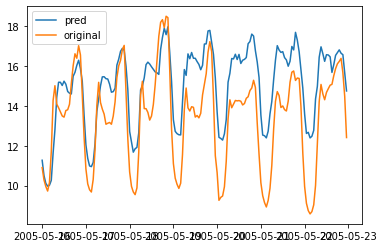

In [54]:
plt.plot(pd.Series(predictions_v1, index=df_area_1_test.index), label='pred')
plt.plot(df_area_1_test, label='original')
plt.legend();

In [55]:
mean_absolute_error(predictions_v1,df_area_1_test)

1.8137231102136027

In [43]:
#using grip to find the best combination of features

param_grid = {'model': [LinearRegression(), GradientBoostingRegressor()], 
              'num_periods_lagged':np.arange(1,24),
              'num_periods_diffed':np.arange(0,1),
              'weekday':[True,False],
              'month':[True,False],
              'holidays': [True,False],
              'rolling' : [[np.mean,np.min,np.max,np.std]]
             }

grid = ParameterGrid(param_grid)

In [45]:
#separeting validation base
df_area_1_grid_train = df_area_1_train[:-24*28]
df_area_1_grid_val   = df_area_1_train[-24*28:]

print(df_area_1_grid_train.shape)
print(df_area_1_grid_val.shape)

(600, 1)
(672, 1)


In [46]:
%%time 


def wrap_model_selection(params): 
    predictions_g = predict_n_periods(series_=df_area_1_grid_train, 
                      n_periods=len(df_area_1_grid_val), 
                      model=params['model'], 
                      num_periods_lagged=params['num_periods_lagged'],
                      num_periods_diffed=params['num_periods_diffed'],
                      weekday=params['weekday'],
                      month=params['month'],
                      rolling=[np.mean,np.max,np.min]
                    )
    return [params,mean_absolute_error(val,predictions)]

res = Parallel(n_jobs=-1)(delayed(wrap_model_selection)(params=params) 
                          for params in tqdm(grid))

ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required.

In [ ]:
df = pd.DataFrame(res, columns=['params','error'])
df.sort_values('error').head()